In [1]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [3]:
import opendatasets as od
import pandas as pd
od.download(
    "https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michaelhong2023
Your Kaggle Key: ··········


100%|██████████| 6.66G/6.66G [01:07<00:00, 105MB/s]


In [4]:
# {"username":"michaelhong2023","key":"5e9fe46d473686d8c0d2c485b4c6ba0b"}

In [5]:
import os 
root = '/content/geolocation-geoguessr-images-50k/compressed_dataset'
kaggleDict = {}
for subdir, dirs, files in os.walk(root):    
    for file in files:
        key, value = os.path.basename(subdir), file
        kaggleDict.setdefault(key, []).append(value)

In [6]:
import random
random.seed(10)

for country in kaggleDict:
  if len(kaggleDict[country]) > 2000:
         print(country)
# Brazil, United States, United Kingdom, France and Japan have samples over 2000

# Will choose United States, Brazil and Japan for diversity
japanSet = kaggleDict['Japan']
brazilSet = kaggleDict['Brazil']
usSet = kaggleDict['United States']

Brazil
France
United Kingdom
Japan
United States


In [7]:
print(len(japanSet))
print(len(brazilSet))
print(len(usSet))

3840
2320
12014


In [8]:
for img in range(len(japanSet)):
  japanSet[img] = root+ '/Japan/'+ japanSet[img]
for img in range(len(brazilSet)):
  brazilSet[img] = root+ '/Brazil/'+ brazilSet[img]
for img in range(len(usSet)):
  usSet[img] = root+ '/United States/'+ usSet[img]
  
japanFiles = random.sample(japanSet, 2000)
brazilFiles = random.sample(brazilSet, 2000)
usFiles = random.sample(usSet, 2000)

In [9]:
print(len(japanFiles))
print(len(brazilFiles))
print(len(usFiles))

2000
2000
2000


In [10]:
print(japanFiles[0])
print(brazilFiles[0])
print(usFiles[0])

/content/geolocation-geoguessr-images-50k/compressed_dataset/Japan/canvas_1629543498.jpg
/content/geolocation-geoguessr-images-50k/compressed_dataset/Brazil/canvas_1629269129.jpg
/content/geolocation-geoguessr-images-50k/compressed_dataset/United States/canvas_1629263812.jpg


In [ ]:
from PIL import Image 
Image.open(japanFiles[0]).show()
Image.open(brazilFiles[0]).show()
Image.open(usFiles[0]).show()

I was originally going to use just Japan, Brazil and Unites States but just decided to try with all classes.

In [44]:
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# create datasets
dataset = datasets.ImageFolder(root=root, transform=transform)

# split datasets into train, val, and test
train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create dataloaders
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get the class names from the dataset
class_names = dataset.classes

In [45]:
def plot_random_image_from_dataset(dataset):
  fig, axs = plt.subplots(1, len(class_names), figsize=(20, 5))
  for i in range(len(class_names)):
      # Get the indices of the images that belong to the current class
      indices = np.where(np.array(dataset.targets) == i)[0]
      # Choose a random index from the indices
      idx = np.random.choice(indices)
      # Get the corresponding image and label
      img, label = dataset[idx]
      # Plot the image and label it with the class name
      axs[i].imshow(img.permute(1, 2, 0))
      axs[i].set_title(class_names[label])
      axs[i].axis("off")
  plt.show()
  return

Number of training images: 29998
Number of validation images: 9999
Number of testing images: 10000


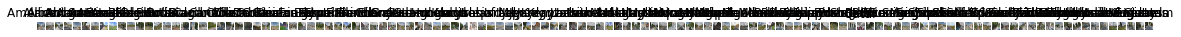

In [33]:
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
plot_random_image_from_dataset(dataset)

In [46]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, num_classes*2)
        self.fc2 = nn.Linear(num_classes*2, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x  

In [35]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [36]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [47]:
def train(model, train_loader, val_loader, batch_size=32, learning_rate = 0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss and the optimizer will be Adam
    # These two were selected because:
    # Cross Entropy Loss - Penalizes the model more heavily when it makes larger errors, which is desirable for image classification
    # Adam - Converges faster than other optimization algorithms, which is important for large-scale image classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test accuracy
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    n = 0 # Iteration number
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            # Forward pass, backward pass, and optimize
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            n += 1          
        
        # Get accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_acc, val_acc, epochs

In [38]:
def plot_curve(acc, epochs, curve_name):
  plt.plot(epochs, acc)
  plt.title(curve_name + " Curve (Default Parameters)")
  plt.xlabel("Epochs")
  plt.ylabel(curve_name + " Accuracy")
  plt.show()
  return

In [48]:
model_default = CNN(len(class_names))
train_acc_default, val_acc_default, epochs_default = train(model_default, train_loader, val_loader)
plot_curve(train_acc_default, epochs_default, "Training")
plot_curve(val_acc_default, epochs_default, "Validation")
# One epoch took like 30 minutes

Training Started...
Epoch 0: Train acc: 0.2446829788652577 |Validation acc: 0.2447244724472447


KeyboardInterrupt: ignored

In [49]:
random.seed(10)

# Select a random subset of the indices
subset_size = len(class_names) * 2
indices = random.sample(range(len(dataset)), subset_size)

# Create a subset dataset
subset_dataset = torch.utils.data.Subset(dataset, indices)

small_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=27, num_workers=1, shuffle=True)

Training Started...
Epoch 0: Train acc: 0.2056451612903226 |Validation acc: 0.2056451612903226
Epoch 1: Train acc: 0.2056451612903226 |Validation acc: 0.2056451612903226
Epoch 2: Train acc: 0.2056451612903226 |Validation acc: 0.2056451612903226
Epoch 3: Train acc: 0.20967741935483872 |Validation acc: 0.20967741935483872
Epoch 4: Train acc: 0.2661290322580645 |Validation acc: 0.2661290322580645
Epoch 5: Train acc: 0.29838709677419356 |Validation acc: 0.29838709677419356
Epoch 6: Train acc: 0.4959677419354839 |Validation acc: 0.4959677419354839
Epoch 7: Train acc: 0.5887096774193549 |Validation acc: 0.5887096774193549
Epoch 8: Train acc: 0.8104838709677419 |Validation acc: 0.8104838709677419
Epoch 9: Train acc: 0.8064516129032258 |Validation acc: 0.8064516129032258
Epoch 10: Train acc: 0.875 |Validation acc: 0.875
Epoch 11: Train acc: 0.9354838709677419 |Validation acc: 0.9354838709677419
Epoch 12: Train acc: 0.9233870967741935 |Validation acc: 0.9233870967741935
Epoch 13: Train acc: 0.9

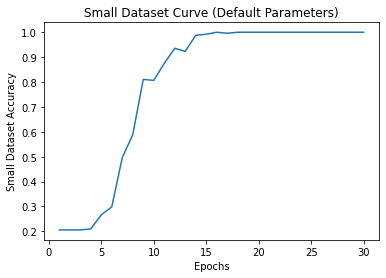

In [50]:
model_default = CNN(len(class_names))
train_acc_default, val_acc_default, epochs_default = train(model_default, small_loader, small_loader)
plot_curve(train_acc_default, epochs_default, "Small Dataset")